# Ground-State: Bosonic Matrix Model

Enrico Rinaldi, July 13, 2022 

In this tutorial we will use the open-source package [NetKet](https://www.netket.org/) to find the ground state (in a variational sense) of a quantum mechanical system of matrices.
This system is referred to as a free bosonic matrix model and was studied in [this PRX Quantum paper](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.010324) using quantum technologies (e.g. based on [qutip](https://qutip.org) and [qiskit](https://qiskit.org)) and Lattice Monte Carlo methods.

Specifically, we will study the system defined by the Hamiltonian: 

$$ \hat{H} = {\rm Tr}\left(\frac{1}{2}\hat{P}_I^2+\frac{m^2}{2}\hat{X}_I^2-\frac{g^2}{4}[\hat{X}_I,\hat{X}_J]^2\right) $$

where 
$$\hat{P}_I=\sum_{\alpha=1}^{N^2-1}\hat{P}_I^\alpha\tau_\alpha$$

and

$$\hat{X}_I=\sum_{\alpha=1}^{N^2-1}\hat{X}_I^\alpha\tau_\alpha$$

for a SU(N) gauge group with $N^2-1$ generators $\tau_\alpha$ (normalized such that ${\rm Tr}(\tau_\alpha \tau_\beta) = \delta_{\alpha\beta}$).
In the Hamiltonian, $g^2$ is the coupling constant representing the strenght of the interaction between matrices $X_I$. The physical states of this system are gauge singlets.
We also set $m^2=1$ so that the first two terms in the Hamiltonian represent a set of free harmonic oscillators with unit frequency.

## 0. Installing Netket 

Installing NetKet is relatively straightforward. For this tutorial, if you are running it locally on your machine, we recommend that you create a clean virtual environment (e.g. with `conda`) and install `NetKet` within (using `pip`): 

```bash
conda create --name netket python pip ipython
conda activate netket
pip install --upgrade netket
```

**If you are on Google Colab**, uncomment and run the following cell to install the required packages.

In [ ]:
#!pip install --upgrade netket

You can check that the installation was succesfull doing 

In [1]:
import netket as nk

You should also check that your version of netket is at least 3.0

In [2]:
print(f"NetKet version: {nk.__version__}")

NetKet version: 3.4.3.dev29+gfe47c195


In [3]:
!python -m netket.tools.info

==         NetKet Diagnostic Informations         ==
NetKet version       : 3.4.3.dev29+gfe47c195

# Python
  - implementation   : CPython
  - version          : 3.10.5
  - distribution     : Clang 13.0.1 
  - path             : /Users/enrythebest/miniforge3/envs/netket-mpi/bin/python

# Host informations
  - System           : macOS-12.4-arm64-arm-64bit
  - Architecture     : arm64
Traceback (most recent call last):
  File "/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/site-packages/netket/tools/info.py", line 167, in <module>
    info()
  File "/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/site-packages/netket/tools/info.py", line 81, in info
    platform_info = cpu_inf

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Defining The Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in. 
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). 
This is done by specifying the Hilbert space of the problem.

For our problem we focus on the gauge group SU(2), which will determine the total number of bosons to be $N^2-1 = 3$ for each matrix ($\alpha, \beta \in \{ 1, 2, 3\}$). 
We will focus on 2 matrices $I, J \in \{ 1, 2 \}$, for a total of 6 bosonic degrees of freedom $\hat{X}_{I,\alpha}$.

### 1.1 The Hilbert space

For each bosonic degree of freedom we work in the basis of the Fock space, truncated up to a finite excitation level (cutoff) represented by $\Lambda$.

In [5]:
Lambda = 4  # cutoff of each bosonic Fock space
N = 6  # number of bosons 

hi = nk.hilbert.Fock(n_max=Lambda-1, N=N)  # n_max -> Maximum occupation for a site (inclusive)

Test if the space is constructed as we expected.
We want each of the $N$ bosons to have up to $\Lambda$ excitations: the total Hilbert space is the tensor product of $N$ individual Fock spaces of dimension $\Lambda$ for a total size of $\Lambda^N = 4^6 = 4096$.

In [6]:
# The size of the hilbert space on every site (we have 4 levels on 6 sites).
hi.shape

(4, 4, 4, 4, 4, 4)

In [7]:
# The total number number of degrees of freedom (6 bosons).
hi.size

6

In [8]:
# The total dimension of the many-body Hilbert space (4^6 = 4096)
hi.n_states

4096

In [9]:
assert Lambda**N == hi.n_states

We have checked that all the dimensions correspond to our expectations. We can think of this as the Hilbert state of a many-body system with $N$ bosonic sites, each with excitations up to level $\Lambda$ (inclusive, starting from 0 to $\Lambda-1$).
In other words, it is a collection of harmonic oscillators in the $\mid n \rangle$ basis.

### 1.2 The free Hamiltonian

We now need to specify the Hamiltonian.
We will use some predefined operators for bosons, such as the `create` and `destroy` operators for each boson in the Hilber state (see the API documentation [here](https://www.netket.org/docs/api.html#pre-defined-operators)).

In this specifc case, $\hat{a}^\dagger_I$ for each boson $I$ (we can regard this index as a _site_ index in `netket`).



In [10]:
from netket.operator.boson import create, destroy

We now start by defining the free part of the Hamiltonian, which is just a collection of harmonic oscillators (for this part we could also use the `number` operator which is pre-defined in `netket`)


In [11]:
# we loop over all "sites" -> loop over N bosons
H_free = sum([0.5 + create(hi, i) * destroy(hi, i) for i in range(N)])


`NetKet` automatically recognizes products of local operators as tensor products and the addition of scalars as if they were multiplied by the identity matrix in the tensor space. In this case, `H_free` acts on a 4096 dimensional space.

In general, when manipulating `NetKet` objects, you should always assume that you can safely operate on them like 
you would in mathematical equations, therefore you can sum and multiply them with ease.

### 1.3 Exact Diagonalization

Let us check this free Hamiltonian, whose eigenvectors are analytically known: the ground state has vacuum energy for $N$ independent harmonic oscillators: $0.5N = 0.5 \cdot 6 = 3$ 

In `netket` we can  convert our Hamiltonian operator into a sparse matrix of size $\Lambda^N \times \Lambda^N $. 

Or we can use the fact that `netket` provides a wrapper for `eigsh` in the form of a Lanczos [exact solver](https://www.netket.org/docs/_generated/exact/netket.exact.lanczos_ed.html#netket.exact.lanczos_ed) which does not require to manipulate the Hamiltonian into a sparse matrix using `.to_sparse`.

In [12]:
eig_vals = nk.exact.lanczos_ed(
    H_free, k=13, compute_eigenvectors=False
)  # args to scipy.sparse.linalg.eighs like can be passed with scipy_args={'tol':1e-8}
print(f"Eigenvalues with exact lanczos (sparse): {eig_vals}")


Eigenvalues with exact lanczos (sparse): [3. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5.]


*Note*: a full (dense) exact diagonalization can also be done for small systems using [this exact solver](https://www.netket.org/docs/_generated/exact/netket.exact.full_ed.html#netket.exact.full_ed)

In [13]:
eig_vals = nk.exact.full_ed(H_free, compute_eigenvectors=False)
print(f"Eigenvalues with exact diag (dense): {eig_vals}\nNumber of eigs: {eig_vals.shape[0]}")

Eigenvalues with exact diag (dense): [ 3.  4.  4. ... 20. 20. 21.]
Number of eigs: 4096


Clearly this is the correct energy for the ground state and we can also see the correct degeneracy (6) of the excited states due to the symmetry of the system (all sites are interchangeable)

### 1.4 The interaction Hamiltonian

We can now continue building our full Hamiltonian by writing the interaction term.
It is convenient to write the interaction using the `position` operators built from the creation and annihilation bosonic operators

$$\hat{x}_I = \frac{1}{\sqrt{2}} \left( \hat{a}^\dagger_I + \hat{a}_I \right)$$


In [14]:
x_list = [(1 / np.sqrt(2))*(create(hi,i)+destroy(hi,i)) for i in range(N)]

The interactoin terms can be written using the Levi-Civita completely antisymmetric tensor with 3 indices or by writing out all the terms by hand:

In [15]:
### Quartic Interaction for bosons
V_b = (
    x_list[2] * x_list[2] * x_list[3] * x_list[3]
    + x_list[2] * x_list[2] * x_list[4] * x_list[4]
    + x_list[1] * x_list[1] * x_list[3] * x_list[3]
    + x_list[1] * x_list[1] * x_list[5] * x_list[5]
    + x_list[0] * x_list[0] * x_list[4] * x_list[4]
    + x_list[0] * x_list[0] * x_list[5] * x_list[5]
    - 2 * x_list[0] * x_list[2] * x_list[3] * x_list[5]
    - 2 * x_list[0] * x_list[1] * x_list[3] * x_list[4]
    - 2 * x_list[1] * x_list[2] * x_list[4] * x_list[5]
)

And the full Hamiltonian with 't Hooft coupling $\lambda = g^2 N_g$ (where $N_g$ is the gauge group number of color,  2 in this example) is

In [16]:
g2N = 0.2  # 't Hooft coupling lambda
H = H_free + (g2N / 2) * V_b

## 2. Exact Diagonalization

We can repeat for the full Hamiltonian at fixed gauge coupling $g^2N_g$ the exact diagonalization procedure we have used on the free Hamiltonian.

When the gauge coupling constant is small, the difference of the energy of the ground state with the free case $g=0$ will be small.

In [17]:
w = nk.exact.full_ed(H, compute_eigenvectors=False)
print(f"Eigenvalues with exact diag (dense): {w}\nNumber of eigs: {w.shape[0]}")


Eigenvalues with exact diag (dense): [ 3.13406307  4.21516634  4.21516634 ... 22.94954115 22.94954115
 23.42952917]
Number of eigs: 4096


Or we can use the Lanczos solver and only approximately retrieve the lowest $k$ eigenvalues (this is much much quicker)

In [18]:
eig_vals = nk.exact.lanczos_ed(
    H, k=4, compute_eigenvectors=False, scipy_args={"tol": 1e-8}
)
print(f"Eigenvalues with exact lanczos (sparse): {eig_vals}")


Eigenvalues with exact lanczos (sparse): [3.13406307 4.21516634 4.21516634 4.21516634]


In [this PRX Quantum paper](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.010324), the author have shown how the ground state energy changes when the truncation level $\Lambda$ of the Fock space is taken to infinity. The convergence to the infinite cutoff limit is exponentially fast and we can work with a small cutoff $\Lambda=4$ in this example, to keep the computational requirements to a minimum.

## 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz: 

$$ \langle X_1,\dots X_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(X_i), $$

where the variational parameters are individual boson's wave functions $\Phi(X_i)$. This is probably a bad ansatz, but it will show how the variational Monte Carlo procedure works in `netket`

We can further write $ \Phi(X) = \sqrt{P(X)}e^{i \phi(X)}$. This is the same form used in the Deep Learning section of [the same preprint cited above](https://arxiv.org/abs/2108.02942), where, instead of the Fock basis for the states, a coordinate basis was used.

In order to simplify the explanation of the Variational Monte Carlo method, we take the phase $\phi=0$, and consider only the modulus of the wave function (the phase will be irrelevant for the ground state of this model).

For the normalized single-boson probability we will take a sigmoid form: 

$$P(X; \gamma) = 1/(1 + e^{-\gamma X})$$
thus depending on the single, real-valued variational parameter $\gamma$. 

In `NetKet` one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).

$$ \langle X_1,\dots X_N| \Psi_{\mathrm{mf}} \rangle = \exp{(\textrm{Model}(X; \theta))} $$

where $\theta$ is a set of parameters.

In this case, the parameter of the model will be just one: $\gamma$.

The Model can be defined using one of the several functional jax frameworks such as Jax/Stax, Flax or Haiku. 
`NetKet` includes several pre-built models and layers built with Flax, so we will be using it for the rest of the notebook.

In [19]:
# always use jax.numpy for automatic differentiation of operations
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module` (or later of nk.nn.Module)
class MF(nn.Module):

    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):

        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values.
        # - The shape of the tensor
        # - The dtype of the tensor.
        gam = self.param("gamma", nn.initializers.normal(), (1,), float)

        # compute the probabilities
        p = nn.log_sigmoid(gam * x)

        # sum the output to return a single number (on a batch of input configurations)
        return 0.5 * jnp.sum(p, axis=-1)


### 3.1 Variational State

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

To actually create a **variational state** with its parameters, the easiest way is to construct a Monte-Carlo-sampled Variational State. 

To do this, we first need to define a sampler.

In [`netket.sampler`](https://www.netket.org/docs/api.html#list-of-samplers) several samplers are defined, each with its own peculiarities.

In the following example, we will be using a simple sampler that chooses the occupation number of each boson at random (uniform between 0 and $\Lambda-1$) one by one.

You can read more about how the sampler works by checking the documentation with `?nk.sampler.MetropolisLocal`

In [20]:
# Create an instance of the model.
# Notice that this does not create the parameters.
mf_model = MF()

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi, n_chains=4)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=2**9)


You can play around with the variational state: for example, you can compute expectation values yourself or inspect it's parameters

In [21]:
# you can inspect the parameters which contain the single
# variational parameter `gamma`
vstate.parameters

FrozenDict({
    gamma: DeviceArray([0.00261021], dtype=float64),
})

In [22]:
# Expectation value: notice that it also provides an error estimate. and the monte carlo chain properties, such as the Gelman-Rubin statistics across chains
vstate.expect(H)

12.72 ± 0.16 [σ²=8.35, R̂=1.0066]

The last cell was run with a randomly initialized parameter $\gamma$ and for 512 samples (notice the metrics for the convergence of the Monte Carlo algorithm in square brackets).

## 4. Variational Monte Carlo

We will now try to optimise $\gamma$ in order to best approximate the ground state of the hamiltonian.

To do so, first I need to pick an iterative optimiser. The following is a choice that can be further optimized later on, depending on the learning curve for the specific ansatz and system.

We choose stochastic gradient descent with a learning rate of $\eta = 0.05$.

Then, we must provide all the elements to the variational monte carlo driver, which takes case of setting up and running the whole optimisation.

For example, the driver can be run for a specific number of iterations. Each iteration will have to run the Monte Carlo sampling defined by the variational state `nk.vqs.MCState`.

In [23]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# Loggers that work together with optimisation drivers are defined in nk.logging.
# RuntimeLog keeps the metrics in memory, JsonLog stores them to a json file which can be read
# as a dict, TensorBoardLog can be used to log to TensorBoard.
log=nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)

# expectation value of the energy
mf_energy = vstate.expect(H)
# compare with the Lanczos exact diagonalization energy eigenvalue
error = abs((mf_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy {mf_energy} \n and relative error: {error*100:.3f}%")


100%|██████████| 300/300 [00:04<00:00, 65.26it/s, Energy=3.207 ± 0.016 [σ²=0.056, R̂=1.0237]]   


Optimized energy 3.1743 ± 0.0094 [σ²=0.0232, R̂=1.0131] 
 and relative error: 1.285%


In [24]:
# we can also inspect the parameter:
print("Final optimized parameter: ",vstate.parameters["gamma"])


Final optimized parameter:  [-5.34820731]


In [25]:
print(
    f"Final optimized energy relative error (with mean-field ansatz): {error*100:.2f}%"
)


Final optimized energy relative error (with mean-field ansatz): 1.29%


Even a very rudimentary ansatz without interactions between the degrees of freedom is sufficient to reach a <10% error on the ground state energy with a single parameter to optimize.

We will see more complicated ansatzë below.

## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields about sub-10% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz. 

We will now take a short-range Jastrow ansatz which is already inlcuded in `netket` as [`nk.models.Jastrow`](https://www.netket.org/docs/_generated/models/netket.models.Jastrow.html#netket.models.Jastrow):

$$\log{\Psi(X)} = \sum_{ij} X_i W_{ij} X_j$$

where $W_{ij}$ is a symmetric matrix of learnable complex parameters (the _kernel_ of the quadratic form).

In [26]:
# change the model: initialize weights with normal distributions
model = nk.models.Jastrow(kernel_init=nn.initializers.normal())

# we use the same MetropolicLocal sapmler as before. Now we sample for longer to get a more accurate result
vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)


In [27]:
# look at the parameters
print(vstate.parameters)

FrozenDict({
    kernel: DeviceArray([[ 0.00732173-0.00556773j, -0.00529138-0.00357844j,
                  -0.00208477-0.00277379j,  0.00638223+0.01796779j,
                   0.00763782-0.01027201j,  0.00444076+0.01405898j],
                 [-0.00287058-0.003213j  , -0.01811796+0.01664156j,
                  -0.00032274-0.00266932j, -0.00123465-0.00658435j,
                  -0.00217496-0.00982552j,  0.00681329-0.00342188j],
                 [ 0.00061385-0.00956469j,  0.00269354+0.00466725j,
                   0.00920346+0.00292229j, -0.00256599+0.01087496j,
                  -0.00136437-0.00963799j, -0.00957885+0.00027523j],
                 [ 0.00390458-0.01294601j,  0.00647984+0.00264337j,
                   0.00775915+0.00261417j, -0.00295561-0.00607042j,
                   0.00179843-0.00666981j, -0.00821019+0.01036066j],
                 [-0.00529658-0.00517435j,  0.00316578-0.00844582j,
                  -0.00295012+0.00682952j,  0.00425731+0.00716369j,
                  -0.00

We then optimize it, however this time we also introduce a stochastic reconfiguration (natural gradient) preconditioner:

In [28]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

preconditioner = nk.optimizer.SR(diag_shift=0.1)

# driver for running the simulation
gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)


We now log the intermediate results of the optimization, so that we can visualize them at a later stage. We also add a callback to the VMC driver in order to save the acceptance rate of the sampling algorithm at each step of the optimization

In [29]:
# define acceptance logger callback
def cb_acc(step, logged_data, driver):
        logged_data["acceptance"] = float(driver.state.sampler_state.acceptance)
        return True

In [30]:
# Loggers that work together with optimisation drivers are defined in nk.logging.
# RuntimeLog keeps the metrics in memory, JsonLog stores them to a json file which can be read
# as a dict, TensorBoardLog can be used to log to TensorBoard.
log = nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log, callback=cb_acc)


100%|██████████| 300/300 [00:06<00:00, 44.18it/s, Energy=3.1554-0.0000j ± 0.0044 [σ²=0.0059, R̂=1.0151]]            


(RuntimeLog():
  keys = ['Energy', 'acceptance'],)

In [31]:
print(f"Final optimized kernel parameters: {vstate.parameters['kernel']}\n")
jas_energy = vstate.expect(H)
error = abs((jas_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error*100:.2f}%")


Final optimized kernel parameters: [[-1.65823686e+00-0.00962541j -7.42581192e-02-0.00103308j
  -7.17795326e-02-0.00439135j -1.05473163e-03+0.01917458j
  -1.05070589e-01-0.01052778j -9.41248119e-02+0.01494898j]
 [-7.18373153e-02-0.00066763j -1.66272273e+00+0.01583437j
  -6.73647791e-02-0.00446322j -1.06808894e-01-0.00860237j
  -1.15101499e-02-0.00206614j -1.12291779e-01-0.0033266j ]
 [-6.90809140e-02-0.01118224j -6.43485004e-02+0.00287335j
  -1.67383562e+00+0.01022874j -1.19012347e-01+0.0129148j
  -1.22906509e-01-0.00846853j -4.16515360e-02-0.00936305j]
 [-3.53237825e-03-0.01173921j -9.90944080e-02+0.00062535j
  -1.08687208e-01+0.00465401j -1.66818109e+00-0.00678996j
  -5.09029021e-02-0.0011079j  -6.91230099e-02+0.00349805j]
 [-1.18004983e-01-0.00543011j -6.16940316e-03-0.00068643j
  -1.24492259e-01+0.00799898j -4.84440217e-02+0.01272559j
  -1.66206942e+00-0.01801056j -6.16085709e-02+0.00285051j]
 [-8.98085763e-02+0.00829191j -1.14835856e-01+0.00561188j
  -2.72255531e-02-0.01400102j -6.

You can now see that this ansatz is almost one order of magnitude more accurate than the mean field! 

In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in NetKet, here we have just used a simple one that stores the intermediate results as values in a dictionary. 

In [32]:
data_jastrow = log.data
print(data_jastrow)

{'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [0, 1, ... 298, 299] (300 steps),
), 'acceptance': History(
   keys  = ['value'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)}


In [33]:
energy_history = data_jastrow["Energy"].Mean.real
energy_error_history = data_jastrow["Energy"].Sigma.real

These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.  

Text(0, 0.5, 'Energy (Re)')

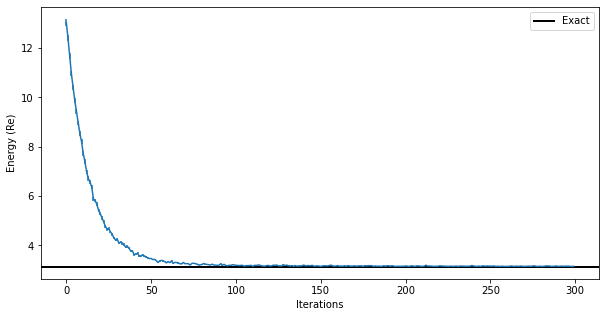

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(data_jastrow["Energy"].iters, energy_history, yerr=energy_error_history)
ax.axhline(y=eig_vals[0], xmin=0, xmax=data_jastrow["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Energy (Re)")


You can also look at the MCMC chain properties, like the Gelman-Rubin statistic (it should be very close to 1.00 for all chains to be equilibrated)

Text(0.5, 0, 'Iterations')

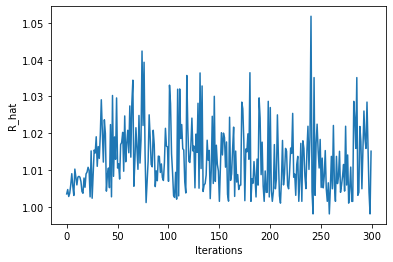

In [35]:
plt.plot(data_jastrow["Energy"].R_hat)
plt.ylabel("R_hat")
plt.xlabel("Iterations")

Some chains have `R_hat` larger than ones, which means they might not have converged within the 1024 samples that we had specified...

Moreover, we can look at the acceptance rate. In this figure below it is clear that the sampler is failing to explore the entirety of the Hilbert space and after 50 iterations the sampling starts failing.

Text(0, 0.5, 'Acc. Rate')

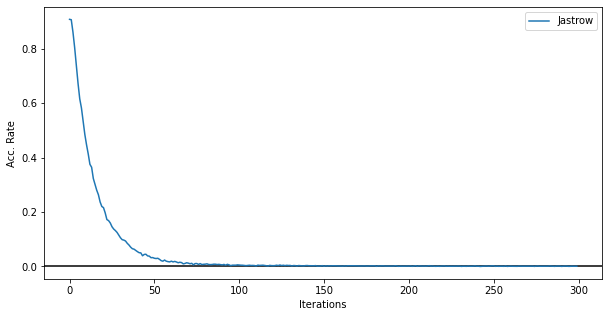

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_jastrow["Energy"].iters, data_jastrow["acceptance"]["value"], label="Jastrow")
ax.axhline(0,c='k')
ax.legend()

ax.set_xlabel('Iterations')
ax.set_ylabel('Acc. Rate')

### 5.1 Exact Sampling

We can change the sampler to an exact sampler which does not suffer from autocorrelation effects and can sample from the exact Born distribution $|\psi(x)|^2$ which is pre-computed on the entire Hilbert space. This is feasible only on small Hilbert spaces, like the one we are using here

In [37]:
# change the model: initialize weights with normal distributions
model = nk.models.Jastrow(kernel_init=nn.initializers.normal())

# Create the an exact sampler over the Hilber space , if it is not too large
sampler = nk.sampler.ExactSampler(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)

The VMC driver and the optimization algorithms can stay the same. Only the sampling has changed

In [38]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

preconditioner = nk.optimizer.SR(diag_shift=0.1)

# driver for running the simulation
gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)

We do not call the `cb_acc` callback here because this exact sampler has no acceptance rate (it is always 1!!)

In [39]:
# Loggers that work together with optimisation drivers are defined in nk.logging.
# RuntimeLog keeps the metrics in memory, JsonLog stores them to a json file which can be read
# as a dict, TensorBoardLog can be used to log to TensorBoard.
log = nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)

100%|██████████| 300/300 [00:05<00:00, 50.21it/s, Energy=3.1575-0.0000j ± 0.0029 [σ²=0.0082]]


(RuntimeLog():
  keys = ['Energy'],)

In [40]:
print(f"Final optimized kernel parameters: {vstate.parameters['kernel']}\n")
jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error*100:.2f}%")

Final optimized kernel parameters: [[-1.70784334-0.0310491j  -0.0632253 +0.00688666j -0.05517124-0.00978079j
  -0.01947021+0.01596723j -0.09776182+0.00208483j -0.09826149+0.01114743j]
 [-0.05792749+0.00524981j -1.71509225-0.01289852j -0.05457469-0.00025632j
  -0.11206383+0.0017977j  -0.0294982 -0.00831419j -0.12414112-0.00679478j]
 [-0.05663309-0.00539664j -0.06869197+0.00600544j -1.69865258+0.00603907j
  -0.0995    +0.00263832j -0.11765438+0.00217108j -0.03167239+0.00067328j]
 [-0.01804256+0.01942781j -0.10896835+0.00052606j -0.10199166-0.00617544j
  -1.7185525 -0.02091704j -0.07227945-0.00594343j -0.06504664+0.0042921j ]
 [-0.1013114 -0.00171485j -0.03446838+0.01227133j -0.10345528+0.00279148j
  -0.07416417-0.00646237j -1.6924236 +0.01275072j -0.07261741-0.01486675j]
 [-0.09719606-0.00885345j -0.11913614-0.00351384j -0.01024796+0.01411088j
  -0.07311966-0.00986676j -0.07860714-0.01276045j -1.68760797-0.01391202j]]

Optimized energy : 3.1607-0.0000j ± 0.0035 [σ²=0.0117]
relative error

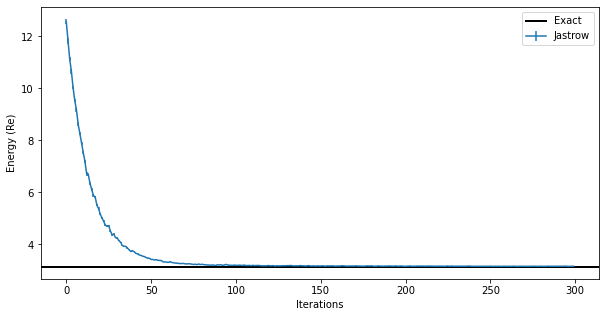

In [41]:
data_jastrow = log.data
energy_history = data_jastrow["Energy"]["Mean"].real
energy_error_history = data_jastrow["Energy"]["Sigma"]

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_jastrow["Energy"].iters, energy_history, yerr=energy_error_history,label="Jastrow")
ax.axhline(y=eig_vals[0], xmin=0, xmax=data_jastrow["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Re)');

The result obtained with the exact sampler is encouraging because we can see that we have achieved the same accuracy on the ground state energy as before. Even if the Metropolis local sampler does not work well for this ground state, the resulting ground state is still the correct one.
The failure in sampling from the computational basis states is due to the fact that, for this system, the ground state is a quantum state that has overlap only on one basis $|s\rangle$. This happens at very small couplings: remember that the zero-coupling limit is just un-coupled harmonic oscillators.

## 6. Neural-Network Quantum State 

We now want to use a more sofisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation. 

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer. 

In [46]:
import flax 

class FFN(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module. This is the ratio of neurons to input dofs
    alpha: int = 1

    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        dense = nn.Dense(features=self.alpha * x.shape[-1], param_dtype=complex)

        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)

        # sum the output
        return jnp.sum(y, axis=-1)


We will keep using the exact sampler to avoid ergodicity issues

In [47]:
# it is easy here to pass the hyper-parameter value
model = FFN(alpha=1)

# Create the an exact sampler over the Hilber space , if it is not too large
sampler = nk.sampler.ExactSampler(hi)

# create the VMC state
vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)

We then proceed to the optimization as before. 

In [48]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)
preconditioner = nk.optimizer.SR(diag_shift=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)

# logging and running : sometimes need to rung longer than 300 to exit a plateaux
log = nk.logging.RuntimeLog()
gs.run(n_iter=300, out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy: {ffn_energy} \nRelative error: {error*100:.2f}%")


100%|██████████| 300/300 [00:05<00:00, 53.07it/s, Energy=3.1520+0.0002j ± 0.0015 [σ²=0.0024]]


Optimized energy: 3.1574+0.0002j ± 0.0025 [σ²=0.0083] 
Relative error: 0.75%


And we can compare the results between the two different ansatze. The fully-connected ansatz needs more iterations to converge:

Text(0, 0.5, 'Energy (Re)')

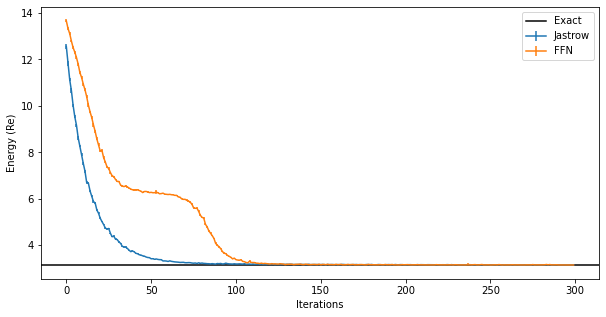

In [49]:
data_FFN = log.data

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean.real,
    yerr=data_jastrow["Energy"].Sigma,
    label="Jastrow",
)
ax.errorbar(
    data_FFN["Energy"].iters,
    data_FFN["Energy"].Mean.real,
    yerr=data_FFN["Energy"].Sigma,
    label="FFN",
)
ax.axhline([eig_vals[0]], xmin=0, xmax=300, color="black", label="Exact")
ax.legend()

ax.set_xlabel("Iterations")
ax.set_ylabel("Energy (Re)")


The plateaux in the figure corresponds to a configuration of bosonic levels where all "sites" are in the ground state but one. Getting out of that plateaux is difficult and requires changing the learning rate or the initial set of parameters.

### 6.1 Increasing the features

We can try to use more _neurons_ in the dense layer to see if we can get a better result.
This can be done simply by instantiating the `FFN` model again with a larger `alpha`.

In [50]:
# it is easy here to pass the hyper-parameter value
model = FFN(alpha=2)

sampler = nk.sampler.ExactSampler(hi)

vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)

optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)
gs.run(n_iter=300, out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy: {ffn_energy} \nRelative error: {error*100:.2f}%")


100%|██████████| 300/300 [00:06<00:00, 46.86it/s, Energy=3.1537-0.0000j ± 0.0020 [σ²=0.0046]]            


Optimized energy: 3.149e+00-3.735e-05j ± 7.850e-17 [σ²=7.889e-31] 
Relative error: 0.49%


This is the best we can do without taking further steps to optimize the learning rate and stochastic gradient descent iterations, which will require more resources.

Clearly we can run for longer, by starting from the current `vstate`

In [51]:
gs.run(n_iter=300, out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy: {ffn_energy} \nRelative error: {error*100:.2f}%")

100%|██████████| 300/300 [00:04<00:00, 68.16it/s, Energy=3.1502-0.0001j ± 0.0010 [σ²=0.0011]]            


Optimized energy: 3.1503-0.0001j ± 0.0011 [σ²=0.0012] 
Relative error: 0.52%


Doubling the optimization iterations has halved the relative error! The very small variance again indicates that the state has a probability distribution peaked on a single state

We can visualize the ground state using `vstate.to_array()` to expand the wave function on the computational basis of states

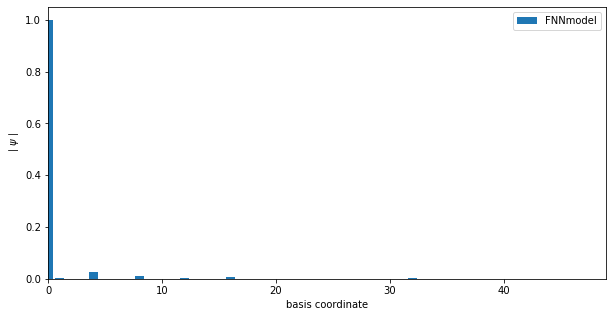

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(np.arange(0,hi.n_states),np.abs(vstate.to_array()),label="FNNmodel")
ax.set_xlim([0,49])
ax.set_xlabel("basis coordinate")
ax.set_ylabel(r"$\mid \psi \mid$")
ax.legend(loc=0)

**Note**: sometimes the FNN ansatz gets stuck on a parameter set that represent the state where only the one "site" is not in the $|0\rangle$ state, in particular if a non-exact sampler (e.g. Metropolis) is used.

In [58]:
model = FFN(alpha=1)

vstate = nk.vqs.MCState(nk.sampler.MetropolisLocal(hi), model, n_samples=2**10)

optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)
gs.run(n_iter=300, out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy: {ffn_energy} \nRelative error: {error*100:.2f}%")


100%|██████████| 300/300 [00:06<00:00, 47.60it/s, Energy=3.1514-0.0002j ± 0.0011 [σ²=0.0012, R̂=1.0073]]            


Optimized energy: 3.1687-0.0003j ± 0.0059 [σ²=0.0199, R̂=1.1009] 
Relative error: 1.10%


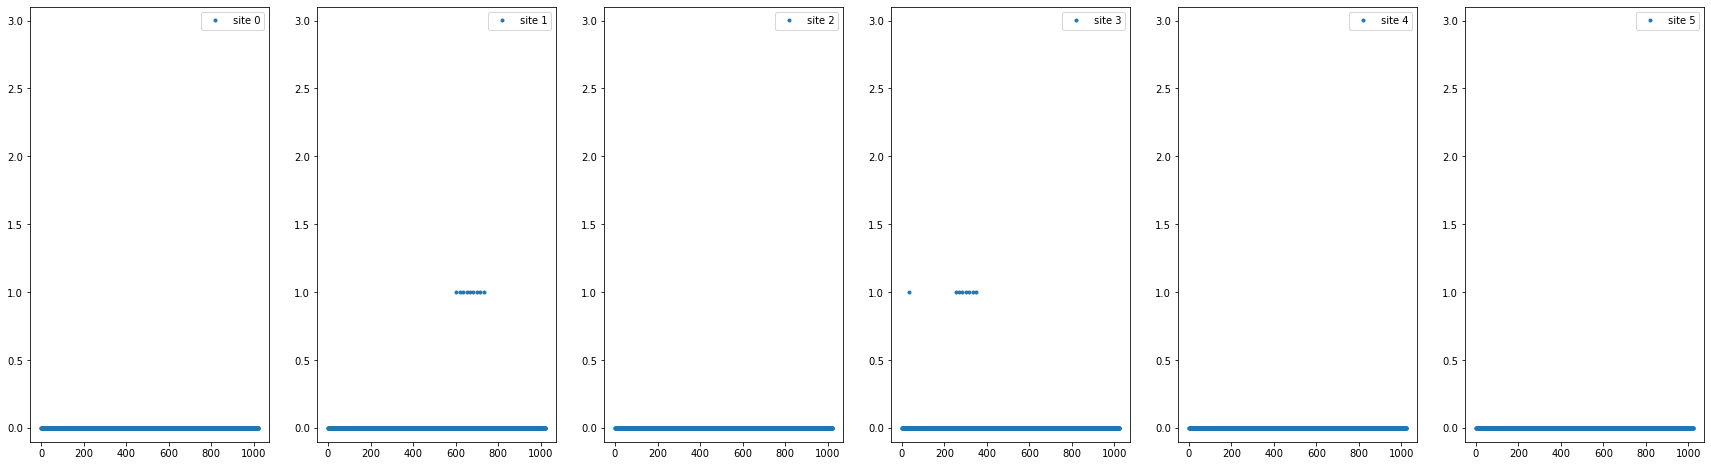

In [59]:
fig, ax = plt.subplots(ncols=N,figsize=(30,8))
for i,axi in enumerate(ax):
    axi.plot(vstate.samples[:,:,i].flatten(), '.', label=f"site {i}")
    axi.set_ylim(-0.1,Lambda-0.9)
    axi.legend()

In [60]:
print(f"Number of parameters (FFN(alpha=1)): {vstate.n_parameters}")

Number of parameters (FFN(alpha=1)): 42


## 7. Autoregressive models

In [this paper](https://arxiv.org/abs/2108.02942), an autoregressive flow model was used to parametrize the modulus of the wave function, while a fully-connected layer was used for the phase. Although the paper consider matrices in the coordinate basis, we here continue using the discrete Fock basis.

Autoregressive models are included in `netket`, together with direct samplers for their conditional distributions (see [this link](https://www.netket.org/docs/_generated/models/netket.models.ARNNDense.html#netket-models-arnndense) for a fully-connected autoregressive model)

In [61]:
model = nk.models.ARNNDense(hilbert=hi, layers=3, features=10)

# the autoregressive model has an exact sampler because of the conditional prob
sampler = nk.sampler.ARDirectSampler(hi)

# With direct sampling, we don't need many samples in each step to form a
# Markov chain, and we don't need to discard samples
vstate = nk.vqs.MCState(sampler, model, n_samples=2**6)


In [62]:
print(f"Number of parameters (ARNNDense): {vstate.n_parameters}")

Number of parameters (ARNNDense): 5544


This model has a much larger number of parameters compared to the fully-connected ansatz we used above.

Then we can call our driver as before

In [63]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)
preconditioner = nk.optimizer.SR(diag_shift=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)

# logging and running
log = nk.logging.RuntimeLog()
gs.run(n_iter=1000, out=log)

arnn_energy = vstate.expect(H)
error = abs((arnn_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy: {arnn_energy} \nRelative error: {error*100:.2f}%")


100%|██████████| 1000/1000 [00:13<00:00, 75.31it/s, Energy=3.150e+00 ± 7.850e-17 [σ²=1.972e-31]]


Optimized energy: 3.150e+00 ± 7.850e-17 [σ²=1.972e-31] 
Relative error: 0.51%


## 8. Measuring Other Properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could measure the generators of the gauge transformations.

We could also use a larger number of samples to have a sufficiently low error bar on their measurement, by changing `vstate.n_samples` on the fly.

The Casimir operator for the gauge group is defined using a combination of $\hat{a}^\dagger_I$ and $\hat{a}_I$ for each boson. We are assuming that sites 0, 1, and 2 are for the 3 gauge dof of one matrix and site 3, 4, and 5 are for the other matrix. Given this assignment we can write

$$ \hat{G}_{\alpha}=i \sum_{\beta, \gamma, I} f_{\alpha \beta \gamma} \hat{a}_{I \beta}^{\dagger} \hat{a}_{I \gamma} $$

using the matrices on the 6 bosonic sites defined at the beginning:

In [64]:
g_list = [0] * 3
g_list[0] = 1j * (
    create(hi, 1) * destroy(hi, 2)
    - create(hi, 2) * destroy(hi, 1)
    + create(hi, 4) * destroy(hi, 5)
    - create(hi, 5) * destroy(hi, 4)
)
g_list[1] = 1j * (
    create(hi, 2) * destroy(hi, 0)
    - create(hi, 0) * destroy(hi, 2)
    + create(hi, 5) * destroy(hi, 3)
    - create(hi, 3) * destroy(hi, 5)
)
g_list[2] = 1j * (
    create(hi, 0) * destroy(hi, 1)
    - create(hi, 1) * destroy(hi, 0)
    + create(hi, 3) * destroy(hi, 4)
    - create(hi, 4) * destroy(hi, 3)
)
G = sum([g * g for g in g_list])


We can sample 1024 times to get a more accurate result. We expect to find zero if the ground state is gauge invariant

In [65]:
vstate.n_samples = 2**10
vstate.expect(G)

0.0020+0.0000j ± 0.0019 [σ²=0.0039]